In [4]:
#Set memory limit such that no memory shortages in k-folding
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-10-05 21:31:08.062486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 21:31:08.786627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2612 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
#Load dataset
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())


In [6]:
#Normalize data
#For each feature, subtract mean (average) and divide by standard deviation
#This means you're taking how much it differs from the average, and then dividing by the standard deviation. 
#Dividing with std means the higher the dispersion from the mean, the more you will divide with, and the lower it will become?
mean = train_data.mean(axis=0)
train_data -= mean
#Notice that you find the standard deviation after you have subtracted
std = train_data.std(axis=0)
train_data /= std

#and for test data also
test_data -= mean
test_data /= std

In [7]:
#Using function because going to be doing multiple models
#No activation on last layer because is regression (so last layer is a linear layer)
#Metric is mae (mean absolute error) how much is off in absolute terms
#Loss is mse (mean squared error) is used often in regression problems

from tensorflow import keras
from tensorflow.keras import layers
def build_model():
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1)
        ]
    )
    model.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])
    return model

In [9]:
#Use k-fold activation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
"""
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()

    model.fit(partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
"""

'\nfor i in range(k):\n    print(f"Processing fold #{i}")\n    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]\n    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]\n\n    partial_train_data = np.concatenate(\n        [train_data[:i * num_val_samples],\n        train_data[(i + 1) * num_val_samples:]],\n        axis=0)\n\n    partial_train_targets = np.concatenate(\n        [train_targets[:i * num_val_samples],\n        train_targets[(i + 1) * num_val_samples:]],\n        axis=0)\n\n    model = build_model()\n\n    model.fit(partial_train_data, partial_train_targets,\n        epochs=num_epochs, batch_size=16, verbose=0)\n    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)\n    all_scores.append(val_mae)\n'

In [10]:
partial_train_data = np.concatenate(
        [train_data[:0 * num_val_samples],
        train_data[(1 + 1) * num_val_samples:]],
        axis=0)
print(partial_train_data.shape)
print(train_data[:1 * num_val_samples].shape)
#Note to what concatenate does. Takes the two tensors and appends one to the other

(202, 13)
(101, 13)


In [11]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)

    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)

    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)
%store average_mae_history

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


UsageError: Unknown variable 'average_mae_history'


In [12]:

%store -r average_mae_history
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[19.333520889282227,
 15.91720175743103,
 11.840876340866089,
 7.8720515966415405,
 5.750345587730408,
 4.670749068260193,
 4.058621942996979,
 3.7009650468826294,
 3.512525498867035,
 3.345078706741333,
 3.216115653514862,
 3.064155876636505,
 3.047878324985504,
 2.9458099603652954,
 2.8931554555892944,
 2.784729778766632,
 2.7536837458610535,
 2.732774078845978,
 2.6725720167160034,
 2.681507706642151,
 2.6551764607429504,
 2.6694259643554688,
 2.5997286438941956,
 2.6418744921684265,
 2.5862632393836975,
 2.592158854007721,
 2.582998275756836,
 2.539825737476349,
 2.5565532445907593,
 2.5337617993354797,
 2.5259379744529724,
 2.501479208469391,
 2.515122711658478,
 2.4822704195976257,
 2.555150866508484,
 2.554695963859558,
 2.469717562198639,
 2.4674498438835144,
 2.5088436603546143,
 2.4711785316467285,
 2.4859983921051025,
 2.4830044507980347,
 2.4452038407325745,
 2.466783344745636,
 2.4505861401557922,
 2.4657036662101746,
 2.4123715460300446,
 2.4331055879592896,
 2.3911773860

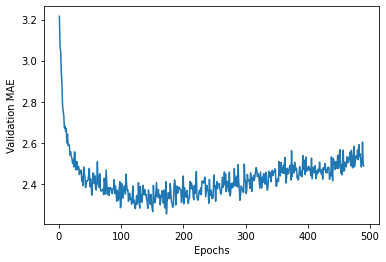

In [15]:
import matplotlib.pyplot as plt
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [16]:
#Find index of lowest validation error in array
opepochs = np.argmin(average_mae_history)

opepochs

182

In [17]:
#Train final model on optimized parameters
new_model = build_model()
new_model.fit(train_data, train_targets, epochs=185, batch_size=16)
test_mse_score, test_mae_score = new_model.evaluate(test_data, test_targets)

Epoch 1/185
26/26 [==============================] - 1s 4ms/step - loss: 482.6572 - mae: 20.1088
Epoch 2/185
26/26 [==============================] - 0s 4ms/step - loss: 292.5204 - mae: 14.9580
Epoch 3/185
26/26 [==============================] - 0s 4ms/step - loss: 129.1495 - mae: 8.9482
Epoch 4/185
26/26 [==============================] - 0s 4ms/step - loss: 63.2394 - mae: 5.8127
Epoch 5/185
26/26 [==============================] - 0s 4ms/step - loss: 38.9628 - mae: 4.4867
Epoch 6/185
26/26 [==============================] - 0s 5ms/step - loss: 28.4915 - mae: 3.8416
Epoch 7/185
26/26 [==============================] - 0s 5ms/step - loss: 24.5006 - mae: 3.4889
Epoch 8/185
26/26 [==============================] - 0s 5ms/step - loss: 21.6410 - mae: 3.2741
Epoch 9/185
26/26 [==============================] - 0s 5ms/step - loss: 19.1223 - mae: 3.0100
Epoch 10/185
26/26 [==============================] - 0s 5ms/step - loss: 17.4082 - mae: 2.9016
Epoch 11/185
26/26 [========================

In [18]:
test_mae_score

2.650785446166992

In [19]:
new_model.predict(test_data)

4/4 [==============================] - 0s 3ms/step


array([[ 8.736494 ],
       [19.334103 ],
       [21.968542 ],
       [31.218765 ],
       [25.831238 ],
       [23.946053 ],
       [27.843657 ],
       [22.357798 ],
       [20.640827 ],
       [22.433006 ],
       [25.828924 ],
       [17.684212 ],
       [17.674225 ],
       [44.379658 ],
       [22.509901 ],
       [20.92092  ],
       [26.242628 ],
       [20.008015 ],
       [20.51049  ],
       [26.174202 ],
       [12.026529 ],
       [12.166316 ],
       [22.4614   ],
       [15.444375 ],
       [19.210146 ],
       [23.22906  ],
       [29.114202 ],
       [28.354126 ],
       [12.174248 ],
       [20.083149 ],
       [19.880182 ],
       [15.967765 ],
       [31.263842 ],
       [24.43709  ],
       [21.321375 ],
       [ 8.974942 ],
       [18.197742 ],
       [16.603662 ],
       [18.326506 ],
       [25.950684 ],
       [30.514523 ],
       [27.410082 ],
       [14.470782 ],
       [45.17587  ],
       [29.331858 ],
       [27.792664 ],
       [28.537539 ],
       [20.36

In [25]:
#Denormalized data for viz
(nonnorm_train_data, nonnorm_train_targets), (nonnorm_test_data, nonnorm_test_targets) = (boston_housing.load_data())

4/4 [==============================] - 0s 2ms/step


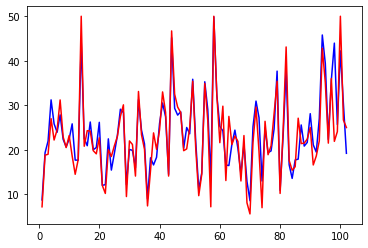

In [31]:
plt.plot(range(1, len(new_model.predict(test_data)) + 1), new_model.predict(test_data), "b", label="prediction")
plt.plot(range(1, len(new_model.predict(test_data)) + 1), nonnorm_test_targets, "r", label="Actual")
plt.show()